In [1]:
import os
from pathlib import Path
compe='playground-series-s3e18'
is_kaggle=os.environ.get('KAGGLE_KERNEL_RUNTYPE','')
if is_kaggle:
    path=Path(f'../input/{compe}')
    ! pip install -Uqq fastai
else:
    import kaggle,zipfile
    path=Path(f'{compe}')
    if not path.exists():
        kaggle.api.competition_download_cli(str(path))
        zipfile.ZipFile(f'{compe}.zip').extractall(path)

In [2]:
from fastai.tabular.all import *
from sklearn.metrics import roc_auc_score

pd.options.display.float_format = '{:.2f}'.format
set_seed(42)

In [3]:
df=pd.read_csv(f'{compe}/train.csv')
df_test=pd.read_csv(f'{compe}/test.csv')
df_sub=pd.read_csv(f'{compe}/sample_submission.csv')
len(df),len(df_test)

(14838, 9893)

In [4]:
print(df.shape)
df.head(3)

(14838, 38)


id  BertzCT  Chi1  Chi1n  Chi1v  Chi2n  Chi2v  Chi3v  Chi4n  EState_VSA1  \
0   0   323.39  9.88   5.88   5.88   4.30   4.30   2.75   1.75         0.00   
1   1   273.72  7.26   4.44   5.83   3.29   4.49   2.20   1.29        45.14   
2   2   521.64 10.91   8.53  11.05   6.67   9.52   5.82   1.77        15.65   

   ...  SlogP_VSA3  VSA_EState9  fr_COO  fr_COO2  EC1  EC2  EC3  EC4  EC5  EC6  
0  ...        4.79        35.53       0        0    1    1    0    0    0    0  
1  ...       13.83        44.71       0        0    0    1    1    0    0    0  
2  ...       17.96        45.66       0        0    1    1    0    0    1    0  

[3 rows x 38 columns]

In [5]:
print(df_test.shape)
df_test.head(2)

(9893, 32)


id  BertzCT  Chi1  Chi1n  Chi1v  Chi2n  Chi2v  Chi3v  Chi4n  \
0  14838   344.63  7.28   4.47   5.83   3.41   4.65   2.10   1.12   
1  14839  1432.41 10.66   7.08   8.07   5.30   5.30   3.92   2.57   

   EState_VSA1  ...  PEOE_VSA14  PEOE_VSA6  PEOE_VSA7  PEOE_VSA8  SMR_VSA10  \
0        49.46  ...       13.51       0.00       0.00       0.00      26.81   
1         0.00  ...        0.00      34.95      98.32       9.61       0.00   

   SMR_VSA5  SlogP_VSA3  VSA_EState9  fr_COO  fr_COO2  
0     24.54        4.79        47.30       1        1  
1     53.38        0.00        43.17       0        0  

[2 rows x 32 columns]

In [6]:
df_sub.head(3)

id  EC1  EC2
0  14838 0.50 0.50
1  14839 0.50 0.50
2  14840 0.50 0.50

### EDA
> Target = EC1,EC2

In [7]:
#checking empty values
df.isna().sum().sum(),df_test.isna().sum().sum() # no empty values !!

(0, 0)

In [8]:
df.describe()

id  BertzCT     Chi1    Chi1n    Chi1v    Chi2n    Chi2v    Chi3v  \
count 14838.00 14838.00 14838.00 14838.00 14838.00 14838.00 14838.00 14838.00   
mean   7418.50   515.15     9.14     5.85     6.74     4.43     5.25     3.42   
std    4283.51   542.46     6.82     4.65     5.87     3.76     4.93     3.44   
min       0.00     0.00     0.00     0.00     0.00     0.00     0.00     0.00   
25%    3709.25   149.10     4.68     2.84     2.93     1.95     2.03     1.16   
50%    7418.50   290.99     6.49     4.05     4.39     2.97     3.24     1.95   
75%   11127.75   652.65    11.17     7.49     8.53     5.79     6.61     4.50   
max   14837.00  4069.96    69.55    50.17    53.43    32.20    34.58    22.88   

         Chi4n  EState_VSA1  ...  SlogP_VSA3  VSA_EState9   fr_COO  fr_COO2  \
count 14838.00     14838.00  ...    14838.00     14838.00 14838.00 14838.00   
mean      1.77        29.20  ...       13.64        49.31     0.46     0.46   
std       1.87        31.73  ...       14.60        29.17     0.67     0.67   
min       0.00         0.00  ...        0.00        -5.43     0.00     0.00   
25%       0.50         5.97  ...        4.79        30.00     0.00     0.00   
50%       1.07        17.35  ...        9.59        41.67     0.00     0.00   
75%       2.53        44.88  ...       14.91        56.09     1.00     1.00   
max      16.07       363.71  ...      115.41       384.45     8.00     8.00   

           EC1      EC2      EC3      EC4      EC5      EC6  
count 14838.00 14838.00 14838.00 14838.00 14838.00 14838.00  
mean      0.67     0.80     0.31     0.28     0.14     0.15  
std       0.47     0.40     0.46     0.45     0.35     0.36  
min       0.00     0.00     0.00     0.00     0.00     0.00  
25%       0.00     1.00     0.00     0.00     0.00     0.00  
50%       1.00     1.00     0.00     0.00     0.00     0.00  
75%       1.00     1.00     1.00     1.00     0.00     0.00  
max       1.00     1.00     1.00     1.00     1.00     1.00  

[8 rows x 38 columns]

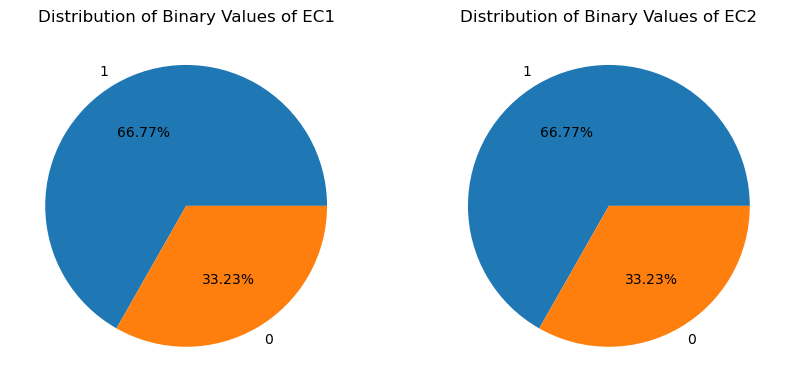

In [24]:
import matplotlib.pyplot as plt
fig,axs=plt.subplots(1,2,figsize=(10,6))
value_counts = df['EC1'].value_counts()
value_counts2 = df['EC2'].value_counts()

axs[0].pie(value_counts, labels=value_counts.index, autopct='%1.2f%%')
axs[1].pie(value_counts, labels=value_counts2.index, autopct='%1.2f%%')

axs[0].set_title('Distribution of Binary Values of EC1')
axs[1].set_title('Distribution of Binary Values of EC2')

plt.show()


In [11]:
cat_cols=[]
num_cols=X.columns.to_list()
num_cols=[x for x in num_cols if x not in cat_cols]
print(num_cols,cat_cols)

['BertzCT', 'Chi1', 'Chi1n', 'Chi1v', 'Chi2n', 'Chi2v', 'Chi3v', 'Chi4n', 'EState_VSA1', 'EState_VSA2', 'ExactMolWt', 'FpDensityMorgan1', 'FpDensityMorgan2', 'FpDensityMorgan3', 'HallKierAlpha', 'HeavyAtomMolWt', 'Kappa3', 'MaxAbsEStateIndex', 'MinEStateIndex', 'NumHeteroatoms', 'PEOE_VSA10', 'PEOE_VSA14', 'PEOE_VSA6', 'PEOE_VSA7', 'PEOE_VSA8', 'SMR_VSA10', 'SMR_VSA5', 'SlogP_VSA3', 'VSA_EState9', 'fr_COO', 'fr_COO2'] []


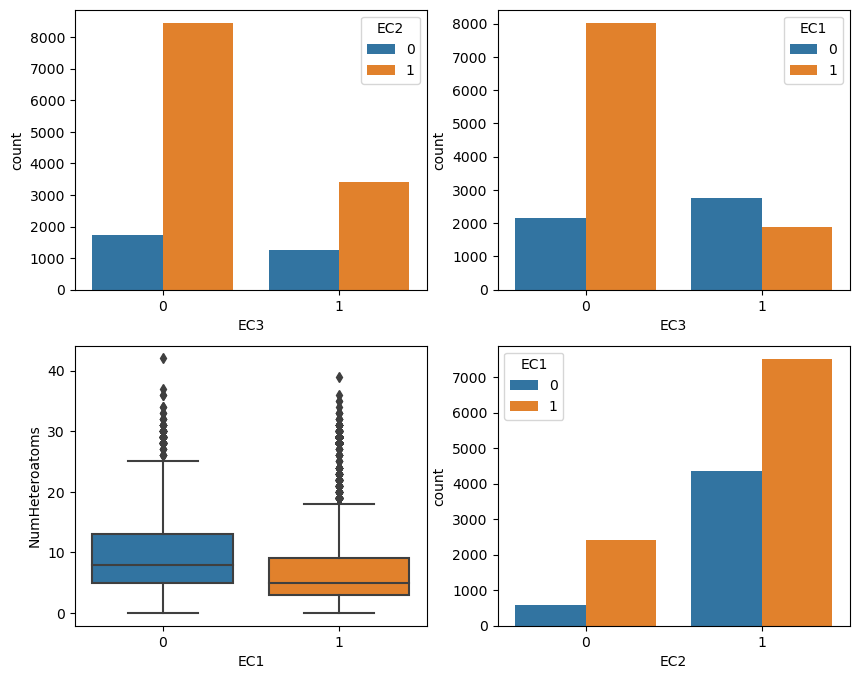

In [12]:
import seaborn as sns
fig,axs=plt.subplots(2,2,figsize=(10,8))
sns.countplot(data=df,x=df['EC2'],hue=df['EC1'],ax=axs[1][1])
sns.countplot(data=df,x=df['EC3'],hue=df['EC1'],ax=axs[0][1])
sns.countplot(data=df,x=df['EC3'],hue=df['EC2'],ax=axs[0][0])

sns.boxplot(data=df,x=df['EC1'],y=df['NumHeteroatoms'],ax=axs[1][0])
plt.show()

In [13]:
# Calculate class proportions
target_proportions = df['EC1'].value_counts() / len(df)
print(target_proportions)

1   0.67
0   0.33
Name: EC1, dtype: float64


In [14]:
# Calculate class proportions
target_proportions = df['EC2'].value_counts() / len(df)
print(target_proportions)

1   0.80
0   0.20
Name: EC2, dtype: float64


#### Feature Engineering

In [46]:
def X_Y(df1):
    X=df1.drop(['id','EC1','EC2','EC3','EC4','EC5','EC6'],axis=1)
    Y=df1['EC1'].astype(str)+df1['EC2'].astype(str)
    return X,Y
X,Y=X_Y(df.copy())

In [45]:
# def X_Y1_Y2(df1):
#     X=df1.drop(['id','EC1','EC2','EC3','EC4','EC5','EC6'],axis=1)
#     Y1=df1['EC1']
#     Y2=df1['EC2']
#     return X,Y1,Y2
# X,Y1,Y2=X_Y1_Y2(df.copy())

#### Making Building ready

In [49]:
cat_cols,num_cols

([],
 ['BertzCT',
  'Chi1',
  'Chi1n',
  'Chi1v',
  'Chi2n',
  'Chi2v',
  'Chi3v',
  'Chi4n',
  'EState_VSA1',
  'EState_VSA2',
  'ExactMolWt',
  'FpDensityMorgan1',
  'FpDensityMorgan2',
  'FpDensityMorgan3',
  'HallKierAlpha',
  'HeavyAtomMolWt',
  'Kappa3',
  'MaxAbsEStateIndex',
  'MinEStateIndex',
  'NumHeteroatoms',
  'PEOE_VSA10',
  'PEOE_VSA14',
  'PEOE_VSA6',
  'PEOE_VSA7',
  'PEOE_VSA8',
  'SMR_VSA10',
  'SMR_VSA5',
  'SlogP_VSA3',
  'VSA_EState9',
  'fr_COO',
  'fr_COO2'])

In [105]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [106]:
len(X_train),len(X_test)

(11870, 2968)

In [107]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()

y_train_encoded = label_encoder.fit_transform(y_train)


In [108]:
y_train_encoded[:10]

array([3, 3, 2, 3, 3, 1, 3, 1, 3, 1])

In [109]:
print(label_encoder.classes_)

['00' '01' '10' '11']


In [63]:
# from sklearn.preprocessing import OneHotEncoder
# onehot_encoder = OneHotEncoder(sparse=False)
# y_train_reshaped = y_train.values.reshape(-1, 1)
# y_train_encoded = onehot_encoder.fit_transform(y_train_reshaped)
# y_train_encoded

### Model Building

In [67]:
import numpy as np
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE        



numeric_preprocessor = Pipeline(
    steps=[
        ("imputation_mean", SimpleImputer(missing_values=np.nan, strategy="mean")),
        ("scaler", StandardScaler()),
    ]
)

categorical_preprocessor = Pipeline(
    steps=[
        (
            "imputation_constant",
            SimpleImputer(fill_value="missing", strategy="most_frequent"),
        ),
        ("onehot", OneHotEncoder(handle_unknown="ignore")),
    ]
)

preprocessor = ColumnTransformer(
    [
        ("categorical", categorical_preprocessor, cat_cols),
        ("numerical", numeric_preprocessor,num_cols),
    ]
)

pipe = make_pipeline(preprocessor, XGBClassifier())
pipe  # click on the diagram below to see the details of each step

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('categorical',
                                                  Pipeline(steps=[('imputation_constant',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  []),
                                                 ('numerical',
                                                  Pipeline(steps=[('imputation_mean',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['BertzCT', 'Ch...
                               feature_types=None, gamma=None, gpu_id=None,
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=100,
                               n_jobs=None, num_parallel_tree=None,
                               predictor=None, random_state=None, ...))])

In [68]:
(X_train.head(2))

BertzCT  Chi1  Chi1n  Chi1v  Chi2n  Chi2v  Chi3v  Chi4n  EState_VSA1  \
36     164.64  5.74   3.38   3.38   2.21   2.21   1.37   0.60         0.00   
9482    91.28  2.64   1.71   1.71   0.93   0.93   0.40   0.00         5.97   

      EState_VSA2  ...  PEOE_VSA14  PEOE_VSA6  PEOE_VSA7  PEOE_VSA8  \
36          17.92  ...        0.00      12.14      17.70       0.00   
9482        12.32  ...        5.97       0.00       0.00       6.04   

      SMR_VSA10  SMR_VSA5  SlogP_VSA3  VSA_EState9  fr_COO  fr_COO2  
36         6.29      0.00        0.00        21.50       0        0  
9482      12.32      0.00        9.59        19.67       1        1  

[2 rows x 31 columns]

#### XGB Classifier

In [110]:
pipe.fit(X_train,y_train_encoded)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('categorical',
                                                  Pipeline(steps=[('imputation_constant',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  []),
                                                 ('numerical',
                                                  Pipeline(steps=[('imputation_mean',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['BertzCT', 'Ch...
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=100,
                               n_jobs=None, num_parallel_tree=None,
                               objective='multi:softprob', predictor=None, ...))])

In [111]:
preds_encoded=pipe.predict(X_test)
preds_encoded

array([3, 3, 3, ..., 3, 1, 3])

In [72]:
# y_pred = preds_encoded.apply(lambda x: label_encoder.inverse_transform(x))
y_pred = label_encoder.inverse_transform(preds_encoded)
y_pred

array(['11', '11', '11', ..., '11', '01', '11'], dtype=object)

In [73]:
arr1 = np.array([x[0] for x in y_pred])
arr2 = np.array([x[1] for x in y_pred])
len(arr1),len(X_test)

(2968, 2968)

In [ ]:
def evaluation(y_true_series,y_preds_encoded,label_encoder=label_encoder)

In [112]:
evaluation(y_test,preds_encoded,label_encoder)

0.564031639430036

In [72]:
df_test.head(2)

id  BertzCT  Chi1  Chi1n  Chi1v  Chi2n  Chi2v  Chi3v  Chi4n  \
0  14838   344.63  7.28   4.47   5.83   3.41   4.65   2.10   1.12   
1  14839  1432.41 10.66   7.08   8.07   5.30   5.30   3.92   2.57   

   EState_VSA1  ...  PEOE_VSA14  PEOE_VSA6  PEOE_VSA7  PEOE_VSA8  SMR_VSA10  \
0        49.46  ...       13.51       0.00       0.00       0.00      26.81   
1         0.00  ...        0.00      34.95      98.32       9.61       0.00   

   SMR_VSA5  SlogP_VSA3  VSA_EState9  fr_COO  fr_COO2  
0     24.54        4.79        47.30       1        1  
1     53.38        0.00        43.17       0        0  

[2 rows x 32 columns]

In [73]:
X_test=df_test.drop('id',axis=1)
X_test.head(2)

BertzCT  Chi1  Chi1n  Chi1v  Chi2n  Chi2v  Chi3v  Chi4n  EState_VSA1  \
0   344.63  7.28   4.47   5.83   3.41   4.65   2.10   1.12        49.46   
1  1432.41 10.66   7.08   8.07   5.30   5.30   3.92   2.57         0.00   

   EState_VSA2  ...  PEOE_VSA14  PEOE_VSA6  PEOE_VSA7  PEOE_VSA8  SMR_VSA10  \
0         0.00  ...       13.51       0.00       0.00       0.00      26.81   
1        29.78  ...        0.00      34.95      98.32       9.61       0.00   

   SMR_VSA5  SlogP_VSA3  VSA_EState9  fr_COO  fr_COO2  
0     24.54        4.79        47.30       1        1  
1     53.38        0.00        43.17       0        0  

[2 rows x 31 columns]

In [76]:
preds1=pipe.predict(X_test)
preds1

array([0, 1, 1, ..., 0, 0, 0])

In [77]:
pipe.fit(X,Y2)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('categorical',
                                                  Pipeline(steps=[('imputation_constant',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='most_frequent'))]),
                                                  []),
                                                 ('numerical',
                                                  Pipeline(steps=[('imputation_mean',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['BertzCT', 'Chi1', 'Chi1n',
                                                   'Chi1v', 'Chi2n', 'Chi2v',
                                                   'Chi3v', 'Chi4n...
                               feature_types=None, gamma=None, gpu_id=None,
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=100,
                               n_jobs=None, num_parallel_tree=None,
                               predictor=None, random_state=None, ...))])

In [81]:
preds2=pipe.predict(X_test)
preds2

array([1, 1, 1, ..., 1, 1, 1])

In [82]:
preds2[:20]

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

#### Random Forest Classifier

In [147]:
X.shape,X_test.shape

((14838, 32), (9893, 32))

In [155]:
X.head(2)

BertzCT  Chi1  Chi1n  Chi1v  Chi2n  Chi2v  Chi3v  Chi4n  EState_VSA1  \
0   323.39  9.88   5.88   5.88   4.30   4.30   2.75   1.75         0.00   
1   273.72  7.26   4.44   5.83   3.29   4.49   2.20   1.29        45.14   

   EState_VSA2  ...  PEOE_VSA6  PEOE_VSA7  PEOE_VSA8  SMR_VSA10  SMR_VSA5  \
0        11.94  ...       0.00       0.00       0.00      17.74      0.00   
1         0.00  ...       0.00       0.00       0.00       7.82     30.71   

   SlogP_VSA3  VSA_EState9  fr_COO  fr_COO2  EC1  
0        4.79        35.53       0        0    1  
1       13.83        44.71       0        0    0  

[2 rows x 32 columns]

In [156]:
from imblearn.pipeline import make_pipeline as make_imb_pipeline
pipe_rf=make_imb_pipeline(SMOTE(random_state=42),preprocessor,RandomForestClassifier())
pipe_rf

Pipeline(steps=[('smote', SMOTE(random_state=42)),
                ('columntransformer',
                 ColumnTransformer(transformers=[('categorical',
                                                  Pipeline(steps=[('imputation_constant',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['EC1']),
                                                 ('numerical',
                                                  Pipeline(steps=[('imputation_mean',
                                                                   SimpleImputer()),
                                                                  ('scal...
                                                   'EState_VSA1', 'EState_VSA2',
                                                   'ExactMolWt',
                                                   'FpDensityMorgan1',
                                                   'FpDensityMorgan2',
                                                   'FpDensityMorgan3',
                                                   'HallKierAlpha',
                                                   'HeavyAtomMolWt', 'Kappa3',
                                                   'MaxAbsEStateIndex',
                                                   'MinEStateIndex',
                                                   'NumHeteroatoms',
                                                   'PEOE_VSA10', 'PEOE_VSA14',
                                                   'PEOE_VSA6', 'PEOE_VSA7',
                                                   'PEOE_VSA8', 'SMR_VSA10',
                                                   'SMR_VSA5', 'SlogP_VSA3',
                                                   'VSA_EState9', 'fr_COO', ...])])),
                ('randomforestclassifier', RandomForestClassifier())])

In [154]:
pipe_rf.fit(X,Y1)

Pipeline(steps=[('smote', SMOTE(random_state=42)),
                ('columntransformer',
                 ColumnTransformer(transformers=[('categorical',
                                                  Pipeline(steps=[('imputation_constant',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['EC1']),
                                                 ('numerical',
                                                  Pipeline(steps=[('imputation_mean',
                                                                   SimpleImputer()),
                                                                  ('scal...
                                                   'EState_VSA1', 'EState_VSA2',
                                                   'ExactMolWt',
                                                   'FpDensityMorgan1',
                                                   'FpDensityMorgan2',
                                                   'FpDensityMorgan3',
                                                   'HallKierAlpha',
                                                   'HeavyAtomMolWt', 'Kappa3',
                                                   'MaxAbsEStateIndex',
                                                   'MinEStateIndex',
                                                   'NumHeteroatoms',
                                                   'PEOE_VSA10', 'PEOE_VSA14',
                                                   'PEOE_VSA6', 'PEOE_VSA7',
                                                   'PEOE_VSA8', 'SMR_VSA10',
                                                   'SMR_VSA5', 'SlogP_VSA3',
                                                   'VSA_EState9', 'fr_COO', ...])])),
                ('randomforestclassifier', RandomForestClassifier())])

In [91]:
preds1=pipe_rf.predict(X_test)
preds1

array([0, 1, 1, ..., 0, 0, 0])

In [113]:
X_test['EC1']=preds1
X['EC1']=df['EC1']
X_test.shape,X.shape

((9893, 32), (14838, 32))

In [110]:
cat_cols=[]
cat_cols.append('EC1')
cat_cols

['EC1']

In [157]:
pipe_rf.fit(X,Y2)

Pipeline(steps=[('smote', SMOTE(random_state=42)),
                ('columntransformer',
                 ColumnTransformer(transformers=[('categorical',
                                                  Pipeline(steps=[('imputation_constant',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['EC1']),
                                                 ('numerical',
                                                  Pipeline(steps=[('imputation_mean',
                                                                   SimpleImputer()),
                                                                  ('scal...
                                                   'EState_VSA1', 'EState_VSA2',
                                                   'ExactMolWt',
                                                   'FpDensityMorgan1',
                                                   'FpDensityMorgan2',
                                                   'FpDensityMorgan3',
                                                   'HallKierAlpha',
                                                   'HeavyAtomMolWt', 'Kappa3',
                                                   'MaxAbsEStateIndex',
                                                   'MinEStateIndex',
                                                   'NumHeteroatoms',
                                                   'PEOE_VSA10', 'PEOE_VSA14',
                                                   'PEOE_VSA6', 'PEOE_VSA7',
                                                   'PEOE_VSA8', 'SMR_VSA10',
                                                   'SMR_VSA5', 'SlogP_VSA3',
                                                   'VSA_EState9', 'fr_COO', ...])])),
                ('randomforestclassifier', RandomForestClassifier())])

In [158]:
preds2=pipe_rf.predict(X_test)
preds2

array([1, 1, 1, ..., 1, 1, 1])

In [159]:
len(preds2),sum(preds2)

(9893, 9282)

In [118]:
(df_test.shape,df.shape)

((9893, 32), (14838, 38))

#### Logistic Regression

In [142]:
from sklearn.linear_model import LogisticRegression
pipe_lr=make_pipeline(preprocessor,LogisticRegression())

In [139]:
X.shape,X_test.shape

((14838, 32), (9893, 32))

In [143]:
pipe_lr.fit(X,Y2)

ValueError: not enough values to unpack (expected 3, got 2)

In [132]:
preds2=pipe_lr.predict(X_test)
preds2

array([1, 1, 1, ..., 1, 1, 1])

In [133]:
len(preds2),sum(preds2)

(9893, 9884)

In [135]:
from imblearn.over_sampling import SMOTE

### Model Analysis

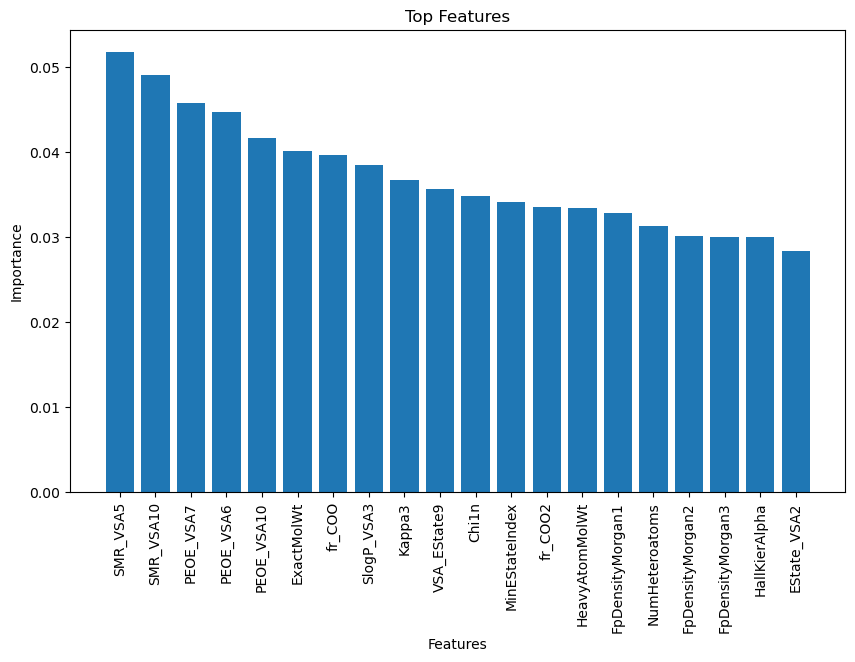

In [172]:
model_imp(pipe_rf)

In [171]:
def model_imp(pipe_obj):
    model_name = pipe_obj.steps[-1][0]
    model = pipe_obj.named_steps[model_name]
    importances = model.feature_importances_
    importances
    feature_names = X.columns
    feature_importances = sorted(zip(importances, feature_names), reverse=True)
    k=20
    top_features = feature_importances[:k]
    features = [feature for importance, feature in top_features]
    importance_values = [importance for importance, feature in top_features]
    plt.figure(figsize=(10, 6))
    plt.bar(features, importance_values)
    plt.xlabel('Features')
    plt.ylabel('Importance')
    plt.title('Top Features')
    plt.xticks(rotation=90)
    plt.show()

#### Testing the values

In [ ]:
arr1 = np.array([x[0] for x in y_pred])
arr2 = np.array([x[1] for x in y_pred])
len(arr1),len(X_test)

In [74]:
y_true=df[['EC1','EC2']]
y_true

EC1  EC2
0        1    1
1        0    1
2        1    1
3        1    1
4        1    0
...    ...  ...
14833    1    1
14834    0    1
14835    1    1
14836    0    1
14837    0    1

[14838 rows x 2 columns]

In [87]:
# y_test1=y_test.to_frame(name='EC')
# y_test
# y_true[['EC1', 'EC2']] = y_test['EC'].str.split('', expand=True)
# y_true.columns
len(y_true)

14838

In [98]:
y_test[['EC1', 'EC2']] = y_test['EC'].str.split('', expand=True).iloc[:, 1:3]
# y_test[['EC1', 'EC2']]
y_test1=y_test.drop('EC',axis=1)
y_test1

EC1 EC2
11988   1   1
13039   0   1
13637   1   1
5537    0   0
8425    1   1
...    ..  ..
1201    1   1
2727    1   1
5987    1   1
7656    0   1
9100    1   1

[2968 rows x 2 columns]

In [104]:
def evaluation(y_true_series,y_preds_encoded,label_encoder=label_encoder):
    y_pred = label_encoder.inverse_transform(y_preds_encoded)
    arr1 = np.array([x[0] for x in y_pred])
    arr2 = np.array([x[1] for x in y_pred])
    y_pred = pd.DataFrame({'EC1': arr1,
                           'EC2':arr2})
    y_true_labeled=y_true_series.to_frame(name='EC')
    y_true_labeled[['EC1', 'EC2']] = y_true_labeled['EC'].str.split('', expand=True).iloc[:, 1:3]
    y_test1=y_true_labeled.drop('EC',axis=1)
    auc_scores = []
    for column in y_pred.columns:
        auc = roc_auc_score(y_test1[column], y_pred[column])
        auc_scores.append(auc)
    average_auc = sum(auc_scores) / len(auc_scores)
    return average_auc

In [101]:
average_auc

0.564031639430036

### Submission

In [70]:
df_sub.head(2)

id  EC1  EC2
0  14838 0.50 0.50
1  14839 0.50 0.50

In [83]:
import subprocess
def make_sub(pred_y1,pred_y2,sub_data=df_test,name='default'):
    df_submission = pd.DataFrame()
    df_submission['id']=df_test['id']
    df_submission['EC1']=pred_y1
    df_submission['EC2']=pred_y2
    df_submission.to_csv(f'submission-{name}.csv', index=False)
    cmd =f'kaggle competitions submit -c {compe} -f submission-{name}.csv -m "Message"'
    subprocess.run(cmd, shell=True)
    print(f'succesully saved - {name}')


In [78]:
preds1=np.full(len(df_test),0.67)
preds2=np.full(len(df_test),0.80)

In [97]:
make_sub(preds1,preds2,name='rf_Pipe')

100%|██████████| 96.6k/96.6k [00:01<00:00, 97.1kB/s]


Successfully submitted to Explore Multi-Label Classification with an Enzyme Substrate Datasetsuccesully saved - rf_Pipe
